2022-04-21 10:10:48.065378: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-21 10:10:48.065731: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 10:10:48.067180: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 2000 images belonging to 2 classes.


2022-04-21 10:10:49.547005: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-21 10:10:49.566328: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 7s 50ms/step - loss: 0.6417 - accuracy: 0.6433 - val_loss: 0.3146 - val_accuracy: 0.8870
Epoch 2/30
100/100 [==============================] - 3s 28ms/step - loss: 0.3061 - accuracy: 0.8674 - val_loss: 0.2833 - val_accuracy: 0.8880
Epoch 3/30
100/100 [==============================] - 3s 29ms/step - loss: 0.2489 - accuracy: 0.8996 - val_loss: 0.2484 - val_accuracy: 0.8990
Epoch 4/30
100/100 [==============================] - 3s 30ms/step - loss: 0.1962 - accuracy: 0.9215 - val_loss: 0.2582 - val_accuracy: 0.8880
Epoch 5/30
100/100 [==============================] - 3s 30ms/step - loss: 0.1612 - accuracy: 0.9437 - val_loss: 0.2618 - val_accuracy: 0.8850
Epoch 6/30
100/100 [==============================] - 2s 24ms/step - loss: 0.1706 - accuracy: 0.9358 - val_loss: 0.2347 - val_accuracy: 0.9070
Epoch 7/30
100/100 [==============================] - 3s 2

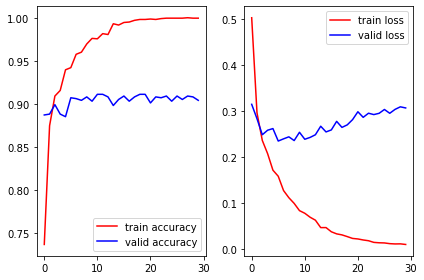

In [1]:
### Transfer Learning ###

### keras는 전이학습을 위해서 VGG16을 제공해준다!
from tensorflow.keras.applications import VGG16

model_base = VGG16(weights='imagenet',  # 어떤 데이터를 가지고 학습한 것을 사용?
                   include_top=False,  # FC layer(classification)를 포함할 것인가?
                   # True로 잡으면 FC layer가 포함된다.
                   # input_shpae의 형식을 맞춰줘야 한다.
                   input_shape=(150,150,3))  # 우리 image의 shape

# print(model_base.summary())

## 우리가 가지고 있는 데이터(개와 고양이)를 VGG16에 통과시켜서
## 이미지의 특성을 ndarray 형태로 저장해야 한다!

import os  # 폴더
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './data/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')  # ./data/cat_dog_small/train
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# 증식 안한다.
datagen = ImageDataGenerator(rescale=1/255)


# 4차원인 feature와 label을 뽑아내는 함수
def extraction_feature(directory, sample_count):
    
    # 일단 shape을 맞추고 0으로 채워둔다.
    features = np.zeros(shape=(sample_count, 4, 4, 512))
                            # 이미지 개수, filter 통과해서 나온 shape
    labels = np.zeros(shape=(sample_count,))
    
    # directory에 있는 파일(image)에서 pixel data와 label을 추출한다.
    generator = datagen.flow_from_directory(
        directory,
        classes=['cats', 'dogs'],  # cats 폴더에 있는 파일들은 label을 0으로
                                  # dogs 폴더에 있는 파일들은 label을 1로
        target_size=(150,150),   # 우리의 image size
        batch_size=20,           # 20개씩 뽑아내기
        class_mode='binary'      # 우리는 cat, dog 2진분류
    )
    
    i = 0
    
    for x_data_batch, t_data_batch in generator:
        feature_batch = model_base.predict(x_data_batch)   # 20개 이미지 특성 추출
        features[i*20:(i+1)*20] = feature_batch  # [0:20] -> [20:40] -> ...
        labels[i*20:(i+1)*20] = t_data_batch
        
        i = i + 1
        
        if i*20 >= sample_count:
            break
            
    return features, labels  # tuple로 return (tuple은 괄호 생략 가능)
    

train_features, train_labels = extraction_feature(train_dir, 2000)
valid_features, valid_labels = extraction_feature(valid_dir, 1000)
test_features, test_labels = extraction_feature(test_dir, 1000)


## 이 ndarray를 이용해서 DNN 학습을 하면 될 것 같다!

train_x_data = np.reshape(train_features,(2000,4*4*512))  # 2차원으로 reshape
train_t_data = train_labels

valid_x_data = np.reshape(valid_features,(1000,4*4*512))  # 2차원으로 reshape
valid_t_data = valid_labels

test_x_data = np.reshape(test_features,(1000,4*4*512))  # 2차원으로 reshape
test_t_data = test_labels

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ model 생성
model = Sequential()


# ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ Input Layer
model.add(Flatten(input_shape=(4*4*512,)))


# ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ Hidden Layer
model.add(Dense(units=256,
                activation='relu'))
model.add(Dropout(rate=0.5))   # overfitting을 방지하기위해 Dropout


# ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ Output Layer
model.add(Dense(units=1,
                activation='sigmoid'))


# ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ optimizer
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ model 학습
history = model.fit(train_x_data,
                    train_t_data,
                    epochs=30,
                    batch_size=20,
                    validation_data=(valid_x_data, valid_t_data))

### history 객체를 이용해서 결과 그래프를 그려보자! ###
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train accuracy')
ax1.plot(valid_acc, color='b', label='valid accuracy')
ax1.legend()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()

plt.tight_layout()
plt.show()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


2022-04-21 11:46:47.044094: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-21 11:46:47.050811: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 11:46:47.056756: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-21 11:46:48.545655: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-21 11:46:48.546299: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/30
100/100 - 380s - loss: 0.6124 - accuracy: 0.6690 - val_loss: 0.4086 - val_accuracy: 0.8460
Epoch 2/30
100/100 - 373s - loss: 0.4911 - accuracy: 0.7605 - val_loss: 0.3551 - val_accuracy: 0.8480
Epoch 3/30
100/100 - 373s - loss: 0.4677 - accuracy: 0.7695 - val_loss: 0.3227 - val_accuracy: 0.8520
Epoch 4/30
100/100 - 372s - loss: 0.4397 - accuracy: 0.7980 - val_loss: 0.3056 - val_accuracy: 0.8560
Epoch 5/30
100/100 - 370s - loss: 0.4221 - accuracy: 0.8000 - val_loss: 0.3184 - val_accuracy: 0.8540
Epoch 6/30
100/100 - 371s - loss: 0.4118 - accuracy: 0.8115 - val_loss: 0.3037 - val_accuracy: 0.8570
Epoch 7/30
100/100 - 368s - loss: 0.4178 - accuracy: 0.7980 - val_loss: 0.2887 - val_accuracy: 0.8720
Epoch 8/30
100/100 - 373s - loss: 0.3856 - accuracy: 0.8315 - val_loss: 0.2974 - val_accuracy: 0.8630
Epoch 9/30
100/100 - 369s - loss: 0.3630 - accuracy: 0.8355 - val_loss: 0.2820 - val_accuracy: 0.8780
Epoch 10/30
100/100 - 370s - loss: 0.3763 - accuracy: 0.8250 - val_loss: 0.2725 - 

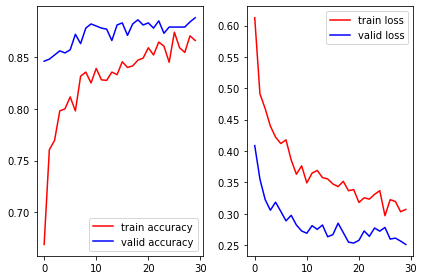

In [4]:
### 이미지 증식을 이용한 전이학습 ###

import os  # 폴더 경로 잡기 위해 필요
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

train_dir = './data/cat_dog_small/train'
valid_dir = './data/cat_dog_small/validation'

# 증식을 하는 ImageDataGenerator (train)
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,      # 0~30도 회전
                                   width_shift_range=0.1,  # 10% 비율로 가로로 움직임
                                   height_shift_range=0.1, # 10% 비율로 세로로
                                   zoom_range=0.2,         # 20% 범위내에서 확대, 축소
                                   horizontal_flip=True,  # 좌우반전 허용
                                   vertical_flip=True,    # 상하반전 허용
                                   fill_mode='nearest')   # 보정 -> 가까운 것으로

# 증식을 하지 않는 ImageDataGenerator (valid)
valid_datagen = ImageDataGenerator(rescale=1/255)

# 데이터를 directory부터 가져온다.
train_generator = train_datagen.flow_from_directory(train_dir,  # directory 명시
                                                    classes=['cats', 'dogs'],
                                                    # cats폴더에 있는 데이터는 label 0
                                                    # dogs폴더에 있는 데이터는 label 1
                                                    target_size=(150,150),  # 데이터 사이즈
                                                    batch_size=20,  # 한번에 가져오는 데이터 개수
                                                    class_mode='binary')  # 2진분류
                                                    # 다중분류시 categorical
    
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    classes=['cats', 'dogs'],
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='binary')
                                                    
# Pretrained Network
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

model_base.trainable = False  # Convolution layer 안의 parameter 동결!

# print(model_base.summary())

### model 구현 ###
model = Sequential()

model.add(model_base)

model.add(Flatten(input_shape=(4*4*512,)))   # ?

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.5))

model.add(Dense(units=1,
                activation='sigmoid'))

# print(model.summary())

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=50,
                    verbose=2)

model.save('./data/cat_dog_small/transfer_learning_cnn_cat_dog_small.h5')

### history 객체를 이용해서 결과 그래프를 그려보자! ###
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train accuracy')
ax1.plot(valid_acc, color='b', label='valid accuracy')
ax1.legend()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()

plt.tight_layout()
plt.show()

# 
# 
# 
# 
# 
# 
# 
# 
# 